## <center> 0. Project Definition

### AIM
To accurately identify clients that are most likely to make a future transaction,
irrespective of the amount of money transacted

## <center> 1. Libraries and Folders

In [1]:
# Data processing library
library(data.table)       # Data manipulation
library(dplyr)            # Data manipulation
library(plyr)             # Data manipulation
library(tidyr)            # Data manipulation
library(stringr)          # String, text processing
library(vita)             # Quickly check variable importance
library(dataPreparation)  # Data preparation library
library(woeBinning)       # Decision tree–based binning for numerical and categorical variables
library(mefa4)            # For 'notin' operator
library(DescTools)        # Winsorization
library(imbalance)        # Oversampling

# Machine Learning Libraries
library(mlr)           # Machine learning framework
library(caret)         # Data processing and machine learning framework
library(MASS)          # LDA
library(randomForest)  # RF
library(gbm)           # Boosting Tree
library(xgboost)       # XGboost
library(adabag)        # Boosting Tree
library(LiblineaR)     # Lasso Regression
library(kknn)          # K-Nearest Neighbours
library(ROCR)          # Performance Metrics

Warning message:
"package 'data.table' was built under R version 3.6.2"Warning message:
"package 'dplyr' was built under R version 3.6.2"
Attaching package: 'dplyr'

The following objects are masked from 'package:data.table':

    between, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'plyr' was built under R version 3.6.2"------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: 'plyr'

The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

Warnin

<br>
<br>
<br>
<br>
<br>

## <center> 2. Functions

In [2]:
# Checking the number of outliers in each feature
FindOutliers <- function(data) {
  lowerq = quantile(data)[2]
  upperq = quantile(data)[4]
  iqr = upperq - lowerq #Or use IQR(data)
  # we identify extreme outliers
  extreme.threshold.upper = (iqr * 1.5) + upperq
  extreme.threshold.lower = lowerq - (iqr * 1.5)
  result <- which(data > extreme.threshold.upper | data < extreme.threshold.lower)
  length(result)
}

# Listing the features containing the outliers
List_Outliers <- function(out, var_list) {
    for (feat in rownames(out)) {
        if (out[feat, "num_outliers"] != 0) {
          var_list <- c(var_list, feat)
        }
    }
    return(var_list)
}

In [3]:
FisherScore <- function(basetable, depvar, IV_list) {

  # Get the unique values of dependent variable
  DV <- unique(basetable[, depvar])
  
  IV_FisherScore <- c()
  
  for (v in IV_list) {
    fs <- abs((mean(basetable[which(basetable[, depvar]==DV[1]), v]) - mean(basetable[which(basetable[, depvar]==DV[2]), v]))) /
      sqrt((var(basetable[which(basetable[, depvar]==DV[1]), v]) + var(basetable[which(basetable[, depvar]==DV[2]), v])))
    IV_FisherScore <- c(IV_FisherScore, fs)
  }
  
  return(data.frame(IV=IV_list, fisher_score=IV_FisherScore))
}

varSelectionFisher <- function(basetable, depvar, IV_list, num_select=50) {

  fs <- FisherScore(basetable, depvar, IV_list)  # Calculate Fisher Score for all IVs
  num_select <- min(num_select, ncol(basetable))  # Top N IVs to be selected
  return(as.vector(fs[order(fs$fisher_score, decreasing=T), ][1:num_select, 'IV']))
}

  "
  Ref:
  ---
  Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights into churn prediction in the telecommunication sector: A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.
  "

[1] "\n  Ref:\n  ---\n  Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights into churn prediction in the telecommunication sector: A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.\n  "

<br>
<br>
<br>
<br>
<br>

## <center> 3. Data Summary and Processing

### 3.1 Setting the Working Directory

In [4]:
setwd("./")

### 3.2 Importing the Datasets

In [5]:
train_full <- read.csv("train.csv")
test_holdout <- read.csv("test.csv")

In [6]:
#Checking the dimensions of the datasets
dim(train_full)
dim(test_holdout)

[1] 200000    202

[1] 200000    201

### 3.3 Data Inspection

#### 3.3.1 Checking for missing values

In [7]:
apply(is.na(train_full), 2, sum)

ID_code  target   var_0   var_1   var_2   var_3   var_4   var_5   var_6   var_7 
      0       0       0       0       0       0       0       0       0       0 
  var_8   var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  var_17 
      0       0       0       0       0       0       0       0       0       0 
 var_18  var_19  var_20  var_21  var_22  var_23  var_24  var_25  var_26  var_27 
      0       0       0       0       0       0       0       0       0       0 
 var_28  var_29  var_30  var_31  var_32  var_33  var_34  var_35  var_36  var_37 
      0       0       0       0       0       0       0       0       0       0 
 var_38  var_39  var_40  var_41  var_42  var_43  var_44  var_45  var_46  var_47 
      0       0       0       0       0       0       0       0       0       0 
 var_48  var_49  var_50  var_51  var_52  var_53  var_54  var_55  var_56  var_57 
      0       0       0       0       0       0       0       0       0       0 
 var_58  var_59  var_60  var_61  var_62  var_63  var_64  var_65  var_66  var_67 
      0       0       0       0       0       0       0       0       0       0 
 var_68  var_69  var_70  var_71  var_72  var_73  var_74  var_75  var_76  var_77 
      0       0       0       0       0       0       0       0       0       0 
 var_78  var_79  var_80  var_81  var_82  var_83  var_84  var_85  var_86  var_87 
      0       0       0       0       0       0       0       0       0       0 
 var_88  var_89  var_90  var_91  var_92  var_93  var_94  var_95  var_96  var_97 
      0       0       0       0       0       0       0       0       0       0 
 var_98  var_99 var_100 var_101 var_102 var_103 var_104 var_105 var_106 var_107 
      0       0       0       0       0       0       0       0       0       0 
var_108 var_109 var_110 var_111 var_112 var_113 var_114 var_115 var_116 var_117 
      0       0       0       0       0       0       0       0       0       0 
var_118 var_119 var_120 var_121 var_122 var_123 var_124 var_125 var_126 var_127 
      0       0       0       0       0       0       0       0       0       0 
var_128 var_129 var_130 var_131 var_132 var_133 var_134 var_135 var_136 var_137 
      0       0       0       0       0       0       0       0       0       0 
var_138 var_139 var_140 var_141 var_142 var_143 var_144 var_145 var_146 var_147 
      0       0       0       0       0       0       0       0       0       0 
var_148 var_149 var_150 var_151 var_152 var_153 var_154 var_155 var_156 var_157 
      0       0       0       0       0       0       0       0       0       0 
var_158 var_159 var_160 var_161 var_162 var_163 var_164 var_165 var_166 var_167 
      0       0       0       0       0       0       0       0       0       0 
var_168 var_169 var_170 var_171 var_172 var_173 var_174 var_175 var_176 var_177 
      0       0       0       0       0       0       0       0       0       0 
var_178 var_179 var_180 var_181 var_182 var_183 var_184 var_185 var_186 var_187 
      0       0       0       0       0       0       0       0       0       0 
var_188 var_189 var_190 var_191 var_192 var_193 var_194 var_195 var_196 var_197 
      0       0       0       0       0       0       0       0       0       0 
var_198 var_199 
      0       0

In [8]:
apply(is.na(train_full), 2, sum)

ID_code  target   var_0   var_1   var_2   var_3   var_4   var_5   var_6   var_7 
      0       0       0       0       0       0       0       0       0       0 
  var_8   var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  var_17 
      0       0       0       0       0       0       0       0       0       0 
 var_18  var_19  var_20  var_21  var_22  var_23  var_24  var_25  var_26  var_27 
      0       0       0       0       0       0       0       0       0       0 
 var_28  var_29  var_30  var_31  var_32  var_33  var_34  var_35  var_36  var_37 
      0       0       0       0       0       0       0       0       0       0 
 var_38  var_39  var_40  var_41  var_42  var_43  var_44  var_45  var_46  var_47 
      0       0       0       0       0       0       0       0       0       0 
 var_48  var_49  var_50  var_51  var_52  var_53  var_54  var_55  var_56  var_57 
      0       0       0       0       0       0       0       0       0       0 
 var_58  var_59  var_60  var_61  var_62  var_63  var_64  var_65  var_66  var_67 
      0       0       0       0       0       0       0       0       0       0 
 var_68  var_69  var_70  var_71  var_72  var_73  var_74  var_75  var_76  var_77 
      0       0       0       0       0       0       0       0       0       0 
 var_78  var_79  var_80  var_81  var_82  var_83  var_84  var_85  var_86  var_87 
      0       0       0       0       0       0       0       0       0       0 
 var_88  var_89  var_90  var_91  var_92  var_93  var_94  var_95  var_96  var_97 
      0       0       0       0       0       0       0       0       0       0 
 var_98  var_99 var_100 var_101 var_102 var_103 var_104 var_105 var_106 var_107 
      0       0       0       0       0       0       0       0       0       0 
var_108 var_109 var_110 var_111 var_112 var_113 var_114 var_115 var_116 var_117 
      0       0       0       0       0       0       0       0       0       0 
var_118 var_119 var_120 var_121 var_122 var_123 var_124 var_125 var_126 var_127 
      0       0       0       0       0       0       0       0       0       0 
var_128 var_129 var_130 var_131 var_132 var_133 var_134 var_135 var_136 var_137 
      0       0       0       0       0       0       0       0       0       0 
var_138 var_139 var_140 var_141 var_142 var_143 var_144 var_145 var_146 var_147 
      0       0       0       0       0       0       0       0       0       0 
var_148 var_149 var_150 var_151 var_152 var_153 var_154 var_155 var_156 var_157 
      0       0       0       0       0       0       0       0       0       0 
var_158 var_159 var_160 var_161 var_162 var_163 var_164 var_165 var_166 var_167 
      0       0       0       0       0       0       0       0       0       0 
var_168 var_169 var_170 var_171 var_172 var_173 var_174 var_175 var_176 var_177 
      0       0       0       0       0       0       0       0       0       0 
var_178 var_179 var_180 var_181 var_182 var_183 var_184 var_185 var_186 var_187 
      0       0       0       0       0       0       0       0       0       0 
var_188 var_189 var_190 var_191 var_192 var_193 var_194 var_195 var_196 var_197 
      0       0       0       0       0       0       0       0       0       0 
var_198 var_199 
      0       0

#### 3.3.2 Splitting the train data

In [9]:
set.seed(1)

# Since the Santander dataset is too large. First subset 10% of the data
subset_idx <- caret::createDataPartition(y=train_full[, 'target'], p=.1, list=F)
subset_whole <- train_full[subset_idx, ]  # To sample 10% of data with evenly distributed target variable

# Partition Data into Train, Validation and Test

train_idx <- caret::createDataPartition(y=subset_whole[, 'target'], p=.6, list=F)
train <- subset_whole[train_idx, ]        # First, Train 60% of subset_whole
valid_test <- subset_whole[-train_idx, ]  # Validation and Test 40% of subset_whole

valid_idx <- caret::createDataPartition(y=valid_test[, 'target'], p=.5, list = F)
valid <- valid_test[valid_idx, ] # 20% of subset_whole is for validation 
test <- valid_test[-valid_idx, ] # 20% of subset_whole is for test of the final chosen model

#### 3.3.3 Checking for imbalance in the target variable

In [10]:
# By number
table(train$target)
table(valid$target)
table(test$target)


    0     1 
10738  1262 


   0    1 
3581  419 


   0    1 
3611  389 

In [11]:
# By percentage
table(train$target) / nrow(train)
table(valid$target) / nrow(valid)
table(test$target) / nrow(test)


        0         1 
0.8948333 0.1051667 


      0       1 
0.89525 0.10475 


      0       1 
0.90275 0.09725 

#### 3.3.4 Checking for outliers

In [12]:
#Selecting the variables
outlier_train <- train[,3:ncol(train)]
outlier_test <- test[,3:ncol(test)]
outlier_valid <- valid[,3:ncol(valid)]
outlier_holdout <- test_holdout[,2:ncol(test_holdout)]

#Applying the function
out_train <- apply(outlier_train, 2, FindOutliers)
out_test <- apply(outlier_test, 2, FindOutliers)
out_valid <- apply(outlier_valid, 2, FindOutliers)
out_holdout <- apply(outlier_holdout, 2, FindOutliers)

#Converting the results to a dataframe
out_train <- as.data.frame(out_train)
out_test <- as.data.frame(out_test)
out_valid <- as.data.frame(out_valid)
out_holdout <- as.data.frame(out_holdout)

#Renaming the columns
colnames(out_train)[1] <- "num_outliers"
colnames(out_test)[1] <- "num_outliers"
colnames(out_valid)[1] <- "num_outliers"
colnames(out_holdout)[1] <- "num_outliers"

#### 3.3.5 Treating the outliers

In [13]:
#Defining an empty list
var_list_train <- c()
var_list_test <- c()
var_list_valid <- c()
var_list_holdout <- c()

#Applying the function
var_list_train <- List_Outliers(out_train, var_list_train)
var_list_test <- List_Outliers(out_test, var_list_test)
var_list_valid <- List_Outliers(out_valid, var_list_valid)
var_list_holdout <- List_Outliers(out_holdout, var_list_holdout)

In [14]:
#Winsorizing the columns containing the outliers

#Train
for (var in var_list_train) {
    train[,var] <- Winsorize(train[,var])
}

#Test
for (var in var_list_test) {
    test[,var] <- Winsorize(test[,var])
}

#Valid
for (var in var_list_valid) {
    valid[,var] <- Winsorize(valid[,var])
}

#Holdout
for (var in var_list_holdout) {
    test_holdout[,var] <- Winsorize(test_holdout[,var])
}

#### 3.3.6 Checking for Multi-Collinearity

In [15]:
#Identifying numeric variables
numericData <- train[,3:ncol(train)]

#Calculate correlation matrix
cor_df <- cor(numericData, use = "complete.obs")

highlycorrelated = findCorrelation(cor_df, cutoff=0.1) # put any value as a "cutoff" 
highlycorrelated = sort(highlycorrelated)
print(highlycorrelated)

numeric(0)


Conclusion: Very low correlation between variables - do not need to remove any variables due to correlation

#### 3.3.7 Treating the imbalance in train data

##### Used SMOTE method to treat the imbalance in the data. It is baked directly into the pipeline 

<br>
<br>
<br>
<br>
<br>

## <center> 4. Standardization

In [ ]:
train_std <- train
test_std <- test 
valid_std <- valid
predict_std <- test_holdout

dv_list <- c('target')  # DV list
std_list <- setdiff(names(train_std), dv_list)  # IV list excluded DV
std_list <- setdiff(std_list, 'ID_code')  # Excluded the client_idb


for (v in std_list) {
    train_std[, v] <- scale(train_std[, v], center=T, scale=T)  # sd = 1, mean = 0
    test_std[, v] <- scale(test_std[, v], center=T, scale=T)  # sd = 1, mean = 0
    predict_std[, v] <- scale(predict_std[, v], center=T, scale=T)  # sd = 1, mean = 0
}

<br>
<br>
<br>
<br>
<br>

## <center> 5. Feature Selection

#### 5.1 Based on Variable Importance

In [16]:
# PIMP-Algorithm For The Permutation Variable Importance Measure
# https://cran.r-project.org/web/packages/vita/vita.pdf

X <- train[, 3:(ncol(train))]
y <- as.factor(train[, 'target'])
rf_model <- randomForest(X, y, mtry=3, ntree=100, importance=T, seed=1)
pimp_varImp <- PIMP(X, y, rf_model, S=10, parallel=F, seed=123)

# check the variable importance
rf_var_imp <- pimp_varImp$VarImp[order(pimp_varImp$VarImp[, 1], decreasing=T), ]
rf_var_imp

var_147       var_139       var_155        var_99        var_22 
 3.419425e-04  3.368810e-04  3.050309e-04  2.846926e-04  2.519934e-04 
      var_154        var_81        var_94        var_72        var_56 
 2.466553e-04  2.350895e-04  2.333614e-04  2.256651e-04  2.188227e-04 
       var_12        var_89       var_152        var_21       var_158 
 2.184414e-04  2.144520e-04  2.122070e-04  2.062718e-04  2.006989e-04 
      var_101        var_53       var_138       var_110        var_32 
 2.003090e-04  1.993070e-04  1.981806e-04  1.951766e-04  1.942365e-04 
       var_86       var_198       var_146       var_174       var_170 
 1.918455e-04  1.847847e-04  1.819817e-04  1.749116e-04  1.728469e-04 
      var_124       var_127         var_1        var_26       var_161 
 1.658874e-04  1.615524e-04  1.566378e-04  1.513584e-04  1.511983e-04 
       var_34       var_187       var_149        var_78       var_120 
 1.462788e-04  1.429075e-04  1.422192e-04  1.416924e-04  1.393451e-04 
       var_58       var_157       var_197       var_148        var_55 
 1.350169e-04  1.341988e-04  1.313831e-04  1.302740e-04  1.297847e-04 
      var_123        var_48        var_91        var_74       var_108 
 1.264649e-04  1.254782e-04  1.235182e-04  1.234939e-04  1.130602e-04 
       var_97        var_75        var_98       var_115       var_135 
 1.103476e-04  1.075281e-04  1.057924e-04  1.054598e-04  1.041684e-04 
       var_36        var_82       var_109        var_25         var_5 
 1.041221e-04  1.032451e-04  1.023599e-04  1.018287e-04  1.002266e-04 
      var_144       var_111         var_6        var_15        var_77 
 9.847961e-05  9.709122e-05  9.488002e-05  9.424010e-05  9.240611e-05 
      var_112         var_9       var_185       var_163        var_59 
 9.058781e-05  8.686297e-05  8.605262e-05  8.541874e-05  8.408666e-05 
       var_54        var_76        var_28       var_188        var_29 
 8.020903e-05  7.563719e-05  7.433420e-05  7.421093e-05  7.047710e-05 
       var_73        var_47        var_79         var_0        var_95 
 6.805256e-05  6.716835e-05  6.658543e-05  6.644312e-05  6.605349e-05 
       var_24        var_64       var_121       var_117       var_156 
 6.269494e-05  6.253855e-05  6.137396e-05  5.854943e-05  5.440874e-05 
       var_57         var_4       var_114        var_18        var_80 
 5.434441e-05  5.319417e-05  5.143093e-05  5.098078e-05  5.070969e-05 
      var_104        var_63       var_134       var_130       var_192 
 4.831312e-05  4.789241e-05  4.714208e-05  4.585169e-05  4.581462e-05 
       var_37       var_145        var_30       var_140        var_84 
 4.385371e-05  4.064622e-05  3.986593e-05  3.869202e-05  3.795754e-05 
       var_50        var_87       var_190       var_177       var_132 
 3.594833e-05  3.503340e-05  3.144809e-05  3.065560e-05  2.972255e-05 
       var_13        var_92        var_69       var_128        var_88 
 2.669699e-05  2.516894e-05  2.510995e-05  2.479770e-05  2.295520e-05 
        var_3        var_33       var_125       var_178        var_19 
 2.289066e-05  2.102130e-05  2.053221e-05  2.035839e-05  1.951556e-05 
      var_153        var_38        var_39       var_100       var_129 
 1.570493e-05  1.343111e-05  1.253619e-05  1.243038e-05  1.209789e-05 
       var_16        var_31        var_46       var_176       var_126 
 1.114064e-05  1.097885e-05  1.036613e-05  9.828700e-06  4.772749e-06 
       var_10        var_83        var_20       var_102       var_159 
 3.083965e-06  2.333206e-06  1.427537e-06  1.163126e-06  1.314863e-08 
      var_142        var_96       var_150        var_62       var_105 
-5.221818e-07 -1.688244e-06 -2.631411e-06 -4.584173e-06 -6.667912e-06 
      var_175       var_164       var_196       var_180       var_199 
-7.345519e-06 -7.405944e-06 -8.130586e-06 -8.380043e-06 -1.199512e-05 
       var_66       var_167        var_68        var_60        var_90 
-1.541732e-05 -1.547759e-05 -1.553160e-05 -1.817694e-05 -2.008602e-05 
        var_8       var_181   

#### 5.2 Based on Fischer Score

In [17]:
# Calculate Fisher Score for all variable
# Get the IV and DV list

dv_list <- c('target')  # DV list
iv_list <- setdiff(names(train), dv_list)  # IV list excluded DV
iv_list <- setdiff(iv_list, 'ID_code')  # Excluded the client_id
fs <- FisherScore(train, dv_list, iv_list)

# Select top 35 variables according to the Fisher Score
best_fs_var <- varSelectionFisher(train, dv_list, iv_list, num_select=35)
best_fs_var

[1] "var_81"  "var_139" "var_6"   "var_146" "var_12"  "var_99"  "var_115"
 [8] "var_184" "var_76"  "var_13"  "var_18"  "var_110" "var_34"  "var_190"
[15] "var_154" "var_9"   "var_91"  "var_1"   "var_166" "var_80"  "var_22" 
[22] "var_0"   "var_78"  "var_67"  "var_133" "var_164" "var_173" "var_179"
[29] "var_109" "var_148" "var_21"  "var_172" "var_75"  "var_192" "var_107"

#### 5.3 Based on Correlation

In [18]:
names <- c("ID_code", "target")

#Initiating empty lists
featured_cols <- c()
p_values <- c()

#Selecting variables with p-value < 0.01
for (column in colnames(train)) {
    if (column %notin% names) {
    p_value <- cor.test(train[[column]], train$target, method = "pearson")[3]
        if (p_value < 0.01) {
            featured_cols <- c(featured_cols, column)
            p_values <- c(p_values, p_value)
        } 
    }
} 

#For the training, validation and test sets
featured_columns <- c("ID_code", "target", featured_cols)

#For the holdout set
featured_col <- c("ID_code", featured_cols)

#Applying the selection to all datasets
train_cor <- train[featured_columns]
valid_cor <- valid[featured_columns]
test_cor <- test[featured_columns]
holdout_cor <- test_holdout[featured_col]

# full dataset
train_full_set <- train_full[featured_columns]

<br>
<br>
<br>
<br>
<br>

## <center> 6. Benchmark Models

In [19]:
train_cor[, 'target'] <- as.factor(train_cor[, 'target'])
valid_cor[, 'target'] <- as.factor(valid_cor[, 'target'])
test_cor[, 'target'] <- as.factor(test_cor[, 'target'])

### 6.1 Setting up the benchmark experiment

In [20]:
# Define the cross validation function
rdesc = makeResampleDesc("CV", iters=3)

# Define the dataset on which the models need to run
train.task <- makeClassifTask(id="ID_code", data=train_cor[, -1], target="target")

# List the performance metric we want to track
meas = list(f1, mmce, ber)

# List the models that need to be benchmarked
lrns = list(makeLearner("classif.randomForest", id = "randomForest"),
            makeLearner("classif.gbm", id = "GBM", distribution = "adaboost"),
            makeLearner("classif.xgboost", id = "XGB"),
            makeLearner("classif.logreg", id = "Logistic"),
            makeLearner("classif.LiblineaRL2LogReg", id = "Lasso")
)

# Conduct the benchmarking experiment
bmr = benchmark(lrns, train.task, rdesc, meas, show.info = FALSE)

### 6.2 Evaluating Model Performance

#### 6.2.1 Based on F1 Score

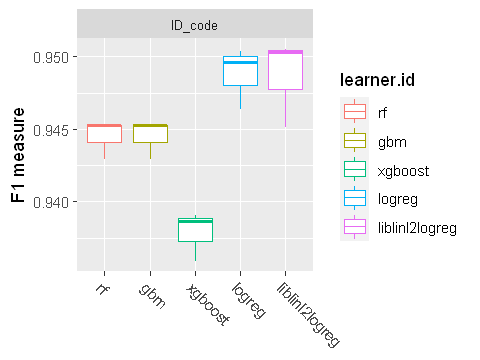

In [21]:
options(repr.plot.width=4, repr.plot.height=3)
plotBMRBoxplots(bmr, measure = f1, order.lrn = getBMRLearnerIds(bmr)) +
                aes(color = learner.id)+
                theme(strip.text.x = element_text(size = 8))

#### 6.2.2 Based on Mean Misclassification Error Rate

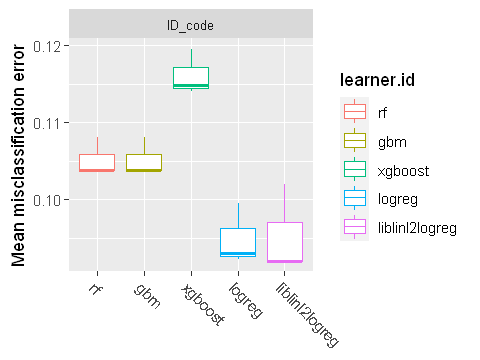

In [22]:
options(repr.plot.width=4, repr.plot.height=3)
plotBMRBoxplots(bmr, measure = mmce, order.lrn = getBMRLearnerIds(bmr)) +
                aes(color = learner.id)+
                theme(strip.text.x = element_text(size = 8))

#### 6.2.3 Based on Balanced Error Rate

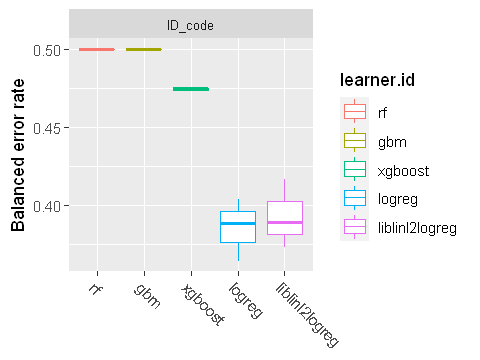

In [23]:
options(repr.plot.width=4, repr.plot.height=3)
plotBMRBoxplots(bmr, measure = ber, order.lrn = getBMRLearnerIds(bmr)) +
                aes(color = learner.id)+
                theme(strip.text.x = element_text(size = 8))

<br>
<br>
<br>
<br>
<br>

## <center> 7. Model Building

### 7.1 Logistic Regression

In [27]:
set.seed(42)

#Set up cross-validation
rdesc = makeResampleDesc("CV", iters=3, predict="both")

# Define the model
learner <- makeLearner("classif.logreg", predict.type="prob", fix.factors.prediction=T)

# Define the upsampler of observations
learner.smote <- makeSMOTEWrapper(learner, sw.rate = 9)

# Define the task
train_task <- makeClassifTask(id="ID_code", data=train_cor[, -1], target="target")

# Set hyper parameter tuning
tune_params <- makeParamSet(
)
ctrl = makeTuneControlGrid()

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner.smote, task=train_task, resampling=rdesc,
      par.set=tune_params, control=ctrl, measures=list(auc, f1))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner.smote, train_task, rdesc, measures=list(auc, f1))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner.smote
}

Resampling: cross-validation
Measures:             auc.test   f1.test    
[Resample] iter 1:    0.8304696  0.8556860  
[Resample] iter 2:    0.8407729  0.8652134  
[Resample] iter 3:    0.8248253  0.8654378  


Aggregated Result: auc.test.mean=0.8320226,f1.test.mean=0.8621124




In [28]:
# Retrain the model with the best hyper-parameters
best_md_lr <- mlr::train(best_learner, train_task)

In [29]:
# Make prediction on valid data
pred_lr <- predict(best_md_lr, newdata = valid_cor[, -1])

# check the results
mlr::performance(pred_lr, measures = mlr::auc)
mlr::performance(pred_lr, measures = mlr::f1)

auc 
0.8275018

f1 
0.8517193

### 7.2 Lasso Regression

In [30]:
set.seed(42)

#Set up cross-validation
rdesc = makeResampleDesc("CV", iters=3, predict="both")

# Define the model
learner <- makeLearner("classif.LiblineaRL2LogReg", predict.type="prob", fix.factors.prediction=T)

# Define the upsampler of observations
learner.smote <- makeSMOTEWrapper(learner, sw.rate = 9)

# Define the task
train_task <- makeClassifTask(id="ID_code", data=train_cor[, -1], target="target")

# Set hyper parameter tuning
tune_params <- makeParamSet(
)
ctrl = makeTuneControlGrid()

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner.smote, task=train_task, resampling=rdesc,
      par.set=tune_params, control=ctrl, measures=list(auc, f1))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner.smote, train_task, rdesc, measures=list(auc, f1))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner.smote
}

Resampling: cross-validation
Measures:             auc.test   f1.test    
[Resample] iter 1:    0.8275724  0.8521847  
[Resample] iter 2:    0.8404938  0.8630284  
[Resample] iter 3:    0.8230012  0.8617234  


Aggregated Result: auc.test.mean=0.8303558,f1.test.mean=0.8589789




In [31]:
# Retrain the model with tbe best hyper-parameters
best_md_lasso <- mlr::train(best_learner, train_task)

In [32]:
# Make prediction on valid data
pred_lasso <- predict(best_md_lasso, newdata = valid_cor[, -1])

# check the results
mlr::performance(pred_lasso, measures = mlr::auc)
mlr::performance(pred_lasso, measures = mlr::f1)

auc 
0.8240375

f1 
0.852891

### 7.3 GBM Adaboost

In [34]:
#Set up cross-validation
rdesc = makeResampleDesc("CV", iters=3, predict="both")

# Define the model
learner <- makeLearner("classif.gbm", predict.type="prob", fix.factors.prediction=T, distribution="adaboost")

# Define the upsampler of observations
learner.smote <- makeSMOTEWrapper(learner, sw.rate = 9)

# Define the task
train_task <- makeClassifTask(id="ID_code", data=train_cor[, -1], target="target")

# Set hyper parameter tuning
tune_params <- makeParamSet(
makeIntegerParam("n.trees", lower = 500, upper = 1000), #number of trees
makeIntegerParam("interaction.depth", lower = 2, upper = 5) #depth of tree
)
ctrl = makeTuneControlRandom(maxit = 50) # grid search was taking too long to run so used random instead

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
      par.set=tune_params, control=ctrl, measures=list(auc, f1))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner.smote, train_task, rdesc, measures=list(measures=list(auc, f1)))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner.smote
}


[Tune] Started tuning learner classif.gbm for parameter set:
                     Type len Def       Constr Req Tunable Trafo
n.trees           integer   -   - 500 to 1e+03   -    TRUE     -
interaction.depth integer   -   -       2 to 5   -    TRUE     -
With control class: TuneControlRandom
Imputation value: -0Imputation value: -0
[Tune-x] 1: n.trees=569; interaction.depth=5
[Tune-y] 1: auc.test.mean=0.8434904,f1.test.mean=0.9498778; time: 1.3 min
[Tune-x] 2: n.trees=656; interaction.depth=3
[Tune-y] 2: auc.test.mean=0.8488139,f1.test.mean=0.9504969; time: 1.1 min
[Tune-x] 3: n.trees=830; interaction.depth=4
[Tune-y] 3: auc.test.mean=0.8499589,f1.test.mean=0.9506849; time: 1.7 min
[Tune-x] 4: n.trees=653; interaction.depth=2
[Tune-y] 4: auc.test.mean=0.8516652,f1.test.mean=0.9501372; time: 0.7 min
[Tune-x] 5: n.trees=647; interaction.depth=2
[Tune-y] 5: auc.test.mean=0.8468849,f1.test.mean=0.9503439; time: 0.7 min
[Tune-x] 6: n.trees=641; interaction.depth=2
[Tune-y] 6: auc.test.mean

In [38]:
# Retrain the model 
best_md_gbm <- mlr::train(best_learner, train_task)

In [39]:
# Make prediction on valid data
pred_gbm <- predict(best_md_gbm, newdata = valid_cor[, -1])

# check the results
mlr::performance(pred_gbm, measures = mlr::auc)
mlr::performance(pred_gbm, measures = mlr::f1)

auc 
0.7008795

f1 
0.8446809

### Train the best model -logistic- on the whole dataset

In [41]:
set.seed(42)

#Set up cross-validation
rdesc = makeResampleDesc("CV", iters=5, predict="both")

# Define the model
learner <- makeLearner("classif.logreg", predict.type="prob", fix.factors.prediction=T)

# Define the task
train_task <- makeClassifTask(id="ID_code", data=train_full_set[, -1], target="target")

# Set hyper parameter tuning
tune_params <- makeParamSet(
)
ctrl = makeTuneControlGrid()

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
      par.set=tune_params, control=ctrl, measures=list(auc, f1))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(auc, f1))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}

# Retrain the model 
best_md_lr <- mlr::train(best_learner, train_task)

pred_lr_holdout <- predict(best_md_lr, newdata = holdout_cor[, -1])

Resampling: cross-validation
Measures:             auc.test   f1.test    
[Resample] iter 1:    0.8449868  0.9516102  
[Resample] iter 2:    0.8379568  0.9526197  
[Resample] iter 3:    0.8406870  0.9528854  


Aggregated Result: auc.test.mean=0.8412102,f1.test.mean=0.9523718




In [42]:
# Check the results
pred_lr_holdout

Prediction: 200000 observations
predict.type: prob
threshold: 0=0.50,1=0.50
time: 0.47
     prob.0      prob.1 response
1 0.8681742 0.131825822        0
2 0.6659516 0.334048429        0
3 0.9599626 0.040037352        0
4 0.8598029 0.140197079        0
5 0.9370436 0.062956432        0
6 0.9925888 0.007411229        0
... (#rows: 200000, #cols: 3)

In [52]:
# Output predicted file
outputLR <- data.frame(ID_code=holdout_cor$ID_code, target=pred_lr_holdout$data$prob.1)
write.csv(outputLR, 'LR_full.csv', row.names=FALSE)

In [54]:
# Output the training base table
write.csv(train_cor, 'train_correlation.csv', row.names=FALSE)